# Baseball
+ This is a Bayesian practice in analyzing Baseball statistics. Many thanks to the great blog @[Variance Explained](http://varianceexplained.org/).

------------
### Objective
Faily evaluating the performance of a player could be hard sometimes when there is little information available. It might be suspicious to say a player, who keeps a record of batting average 8/10, is better than another one, who gets an average 200/500. Now, let Bayesian Statistics make help. This practice was conducted under the guidance from blog @[Variance Explained](http://varianceexplained.org/). It covers empirical Bayesian prior estimates, hierarchical modeling, mixture model, hypothese testing and simulation.

### Data Description
To access to the data, click the [link](https://github.com/chadwickbureau/baseballdatabank)!

Variable|Definition|Note
---|---|---
playerID|A unique code asssigned to each player|The playerID links the data in this file with records in the other files
nameFirst|Player's first name|
nameLast|Player's last name|
yearID|Year|
lgID|League|
AB|At Bats| 
H|Hits|
2B|Doubles|
3B|Triples|
HR|Homeruns|
G|Games played|

-----------------
### Under Construction
Credible Interval, Hypothesis testing, FDR control, Simulation, Document Formatting

-----------------

In [1]:
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import math

In [2]:
batting = pd.read_csv('batting.csv')
master = pd.read_csv('master.csv')
pitching = pd.read_csv('pitching.csv')

In [3]:
pitching = pitching.groupby('playerID',as_index = False).sum()
pitching = pitching[pitching.G > 3]
batting = batting[(batting.lgID == 'NL') & (batting.yearID > 1980)]
batting = batting.groupby('playerID',as_index = False).sum()
batting = batting[(batting.AB > 20)]
batting['isPitcher'] = batting.playerID.isin(pitching.playerID)
master[['nameFirst','nameLast']] = master[['nameFirst','nameLast']].fillna('NaN')
master['name'] = master[['nameFirst','nameLast']].apply(lambda x: ' '.join(x), axis = 1)

In [4]:
df = pd.merge(batting, master, how = 'left', on = 'playerID')

In [5]:
career = df[['name','H','AB','isPitcher']]
career['Average_rate'] = df.H.astype(float) / df.AB

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [6]:
career.head(10)

,name,H,AB,isPitcher,Average_rate
0,Jeff Abbott,11,42,False,0.261905
1,Jim Abbott,2,21,True,0.095238
2,Kurt Abbott,475,1860,False,0.255376
3,Kyle Abbott,3,31,True,0.096774
4,Reggie Abercrombie,86,386,False,0.222798
5,Shawn Abner,110,531,False,0.207156
6,Bobby Abreu,1607,5395,False,0.297868
7,Tony Abreu,129,509,False,0.253438
8,Jose Acevedo,8,101,True,0.079208
9,Juan Acevedo,6,65,True,0.092308


I. Prior Distribution Parameters Estimation

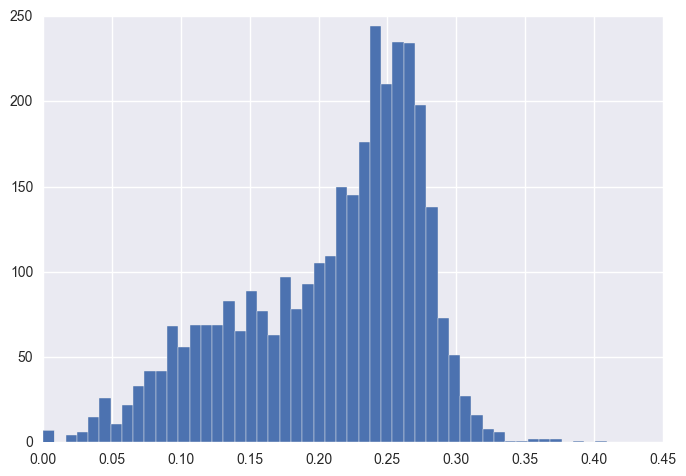

In [7]:
plt.figure()
plt.hist(x = career.Average_rate, bins = 50)
plt.show()

a. Raw MLE

In [8]:
import scipy as sp
alpha0, beta0, loc0, scale0 = sp.stats.beta.fit(career.Average_rate)

In [9]:
career['Average_rate0'] = (alpha0 + career.H) / (career.AB + alpha0 + beta0)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


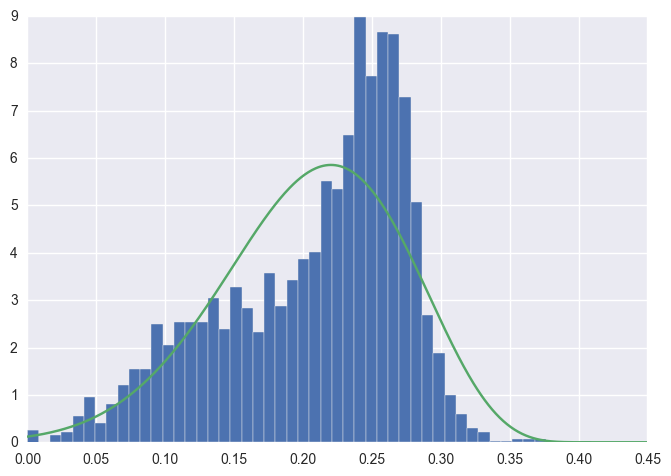

In [10]:
plt.figure()
plt.hist(x = career.Average_rate, bins = 50, normed = True)
x = np.linspace(0,0.45,500)
pdf = sp.stats.beta.pdf(x, alpha0, beta0, loc0, scale0) 
plt.plot(x, pdf, '-')
plt.show()

b. Mixture Effect Model

In [11]:
def mix_beta(data, n, k):
    
    np.random.seed(2017)
    z = np.array([np.random.permutation([0] * (k-1) + [1]) for i in range(len(data))])
    p = z.sum(axis = 0) / float(len(data))
    lp = np.array([0.0] * len(data) * k).reshape(len(data),k)

    para = {'alpha': np.ndarray((n,k)),
            'beta':np.ndarray((n,k)),
            'location':np.ndarray((n,k)),
            'scale':np.ndarray((n,k)),
            'prior':np.ndarray((n,k))}
    
    for i in range(n):
        for j in range(k):
            a, b, l, s = sp.stats.beta.fit(data[z[:,j] == 1])
            lp[:,j] = sp.stats.beta.pdf(data, a, b, l, s)
            para['alpha'][i,j] = a
            para['beta'][i,j] = b
            para['location'][i,j] = l
            para['scale'][i,j] = s
        z = np.apply_along_axis(lambda x: x == np.max(x), 1 , lp)
        p = z.sum(axis = 0) / float(len(data))
        para['prior'][i,:] = p

    return para

In [12]:
from scipy.optimize import minimize
from scipy.special import gammaln

def bb(s, n, a, b):
    return gammaln(n+1) + gammaln(s+a) + gammaln(n-s+b) + gammaln(a+b) - (gammaln(s+1) + gammaln(n-s+1) + gammaln(a) + gammaln(b) + gammaln(a + b + n))

def ll_bb(para, data):
    alpha = para[0]
    beta = para[1]
    ll = - np.sum(bb(data.H, data.AB, alpha, beta))
    return ll

def fit_mle_bb(data):
    res = minimize(ll_bb, x0 = np.array([18,70]), args = data, method = 'BFGS')
    alpha, beta = res.x
    return alpha, beta
    
def mix_bb(data, n, k):
    
    np.random.seed(2017)
    z = np.array([np.random.permutation([0] * (k-1) + [1]) for i in range(len(data))])
    p = z.sum(axis = 0) / float(len(data))
    lp = np.array([0.0] * len(data) * k).reshape(len(data),k)

    para = {'alpha': np.ndarray((n,k)),
            'beta':np.ndarray((n,k)),
            'prior':np.ndarray((n,k))}
    
    for i in range(n):
        for j in range(k):
            a, b = fit_mle_bb(data[z[:,j] == 1])
            lp[:,j] = np.exp(bb(data.H, data.AB, a, b))
            para['alpha'][i,j] = a
            para['beta'][i,j] = b
        z = np.apply_along_axis(lambda x: x == np.max(x), 1 , lp)
        p = z.sum(axis = 0) / float(len(data))
        para['prior'][i,:] = p

    return para

In [13]:
para = mix_beta(career.Average_rate, 10, 2)
para_bb = mix_bb(career, 10, 2)

//anaconda/lib/python2.7/site-packages/scipy/stats/_continuous_distns.py:407: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*sqrt(a + b + 1) / (a + b + 2) / sqrt(a*b)
//anaconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [14]:
alpha1, beta1, loc1, scale1, prior1 = para['alpha'][-1], para['beta'][-1], para['location'][-1], para['scale'][-1], para['prior'][-1]

In [15]:
alpha1_bb, beta1_bb, prior1_bb = para_bb['alpha'][-1], para_bb['beta'][-1], para_bb['prior'][-1]

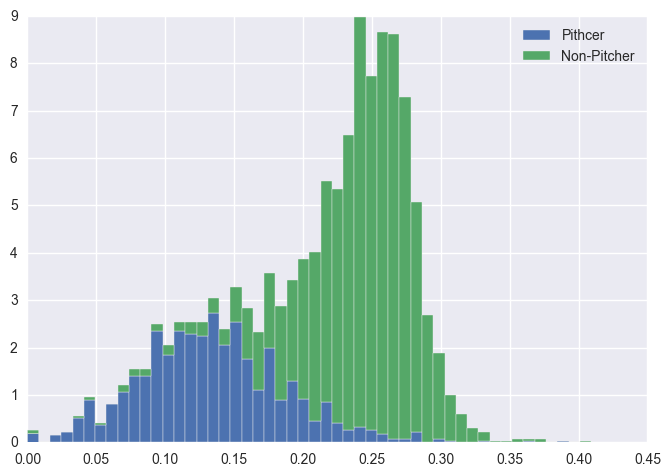

In [16]:
plt.figure()
plt.hist(x = [career.Average_rate[career.isPitcher == True], career.Average_rate[career.isPitcher == False]], bins = 50, stacked=True, label = ['Pithcer','Non-Pitcher'], rwidth = 1, normed = True,)
plt.legend(loc='best')
plt.show()

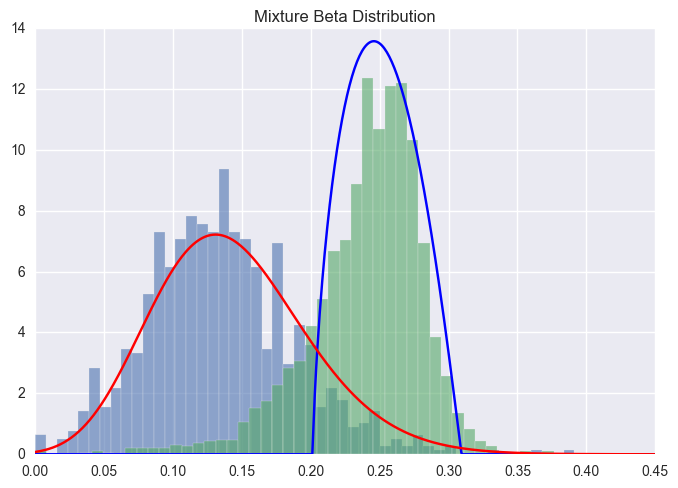

In [17]:
plt.figure()
plt.title('Mixture Beta Distribution')
plt.hist(x = career.Average_rate[career.isPitcher == True], bins = 50, normed = True, alpha = 0.6, label = 'Pitcher')
plt.hist(x = career.Average_rate[career.isPitcher == False], bins = 50, normed = True, alpha = 0.6, label = 'Non-Pitcher')
x = np.linspace(0,0.45,500)
pdf1 = sp.stats.beta.pdf(x, alpha1[0], beta1[0], loc1[0], scale1[0])
pdf2 = sp.stats.beta.pdf(x, alpha1[1], beta1[1], loc1[1], scale1[1])
plt.plot(x, pdf1, 'b-')
plt.plot(x, pdf2, 'r-')
plt.show()

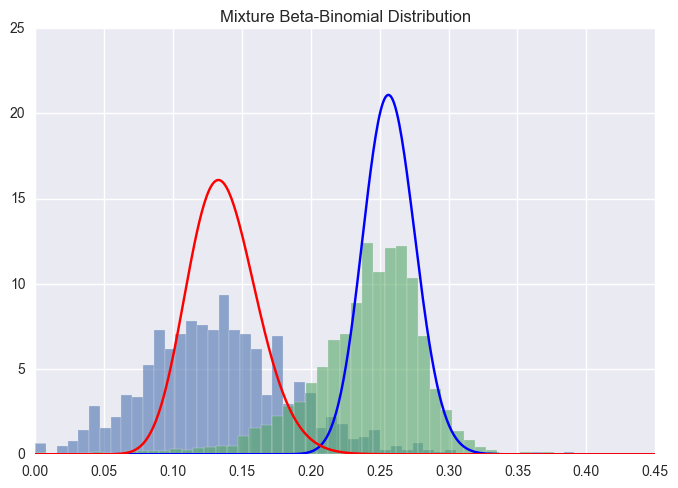

In [18]:
plt.figure()
plt.title('Mixture Beta-Binomial Distribution')
plt.hist(x = career.Average_rate[career.isPitcher == True], bins = 50, normed = True, alpha = 0.6, label = 'Pitcher')
plt.hist(x = career.Average_rate[career.isPitcher == False], bins = 50, normed = True, alpha = 0.6, label = 'Non-Pitcher')
x = np.linspace(0,0.45,500)
pdf1 = sp.stats.beta.pdf(x, alpha1_bb[0], beta1_bb[0])
pdf2 = sp.stats.beta.pdf(x, alpha1_bb[1], beta1_bb[1])
plt.plot(x, pdf1, 'b-')
plt.plot(x, pdf2, 'r-')
plt.show()

In [19]:
#Assign using beta distribution
post1 = sp.stats.beta.pdf(career.Average_rate, alpha1[0], beta1[0], loc1[0], scale1[0]) * prior1[0]
post2 = sp.stats.beta.pdf(career.Average_rate, alpha1[1], beta1[1], loc1[1], scale1[1]) * prior1[1]
isPitcher_guess1 = post2 > post1

In [20]:
#Assign using beta-binomial distribution
post1 = bb(career.H, career.AB, alpha1_bb[0], beta1_bb[0]) * prior1_bb[0]
post2 = bb(career.H, career.AB, alpha1_bb[1], beta1_bb[1]) * prior1_bb[1]
isPitcher_guess2 = post2 > post1

In [21]:
isPitcher = pd.DataFrame({'Truth': career.isPitcher,
                          'Beta': isPitcher_guess1,
                          'Beta-Binomial': isPitcher_guess2})

In [24]:
ct1 = pd.crosstab(isPitcher.Truth, isPitcher['Beta'], margins= True)
ct2 = pd.crosstab(isPitcher.Truth, isPitcher['Beta-Binomial'], margins= True)

In [28]:
print ct1
print '--------------------------------'
print ct2

Beta   False  True   All
Truth                   
False   1908   415  2323
True      88   908   996
All     1996  1323  3319
--------------------------------
Beta-Binomial  False  True   All
Truth                           
False           1524   799  2323
True              30   966   996
All             1554  1765  3319


In [29]:
accuracy = np.array([sum(isPitcher.Truth == isPitcher['Beta'])/float(len(isPitcher)), sum(isPitcher.Truth == isPitcher['Beta-Binomial'])/float(len(isPitcher))])
precision = (np.array([ct1[1][1], ct2[1][1]]) + 0.0) / np.array([ct1[1][2], ct2[1][2]])
recall = (np.array([ct1[1][1], ct2[1][1]]) + 0.0) / np.array([ct1['All'][1], ct2['All'][1]])
f1 = 2 * precision * recall / (precision + recall)
isPitcher_score = pd.DataFrame({'Accuracy': accuracy,
                                'Precision': precision,
                                'Recall': recall,
                                'F1': f1}, index=['Beta','Beta-Binomial'])
isPitcher_score

,Accuracy,F1,Precision,Recall
Beta,0.848448,0.783096,0.686319,0.911647
Beta-Binomial,0.750226,0.699746,0.547309,0.969880


c. Mixture Effect Model with Factors

c1. Factor AB

In [30]:
import statsmodels.api as sm
import betareg

In [31]:
def mix_beta_ab(data, n, k):
    
    np.random.seed(2017)
    z = np.array([np.random.permutation([0] * (k-1) + [1]) for i in range(len(data))])
    p = z.sum(axis = 0) / float(len(data))
    lp = np.array([0.0] * len(data) * k).reshape(len(data),k)

    para = {'prior':np.ndarray((n,k)),
            'coef0':np.ndarray((n,k)),
            'coef1':np.ndarray((n,k)),
            'sigma0': np.ndarray((n,k))}
    
    for i in range(n):
        for j in range(k):
            model = betareg.Beta(endog = data.Average_rate[z[:,j] == 1], exog = np.log(data.AB[z[:,j] == 1]))
            c0, c1 = model.fit().params
            sigma0 = np.std(1 / (1. + np.exp(- data.Average_rate[z[:,j] == 1])) - c0 - c1 * np.log(data.AB[z[:,j] == 1]))
            a = (c0 + c1 * np.log(data.AB)) / sigma0
            b = (1 - (c0 + c1 * np.log(data.AB))) / sigma0
            lp[:,j] = sp.stats.beta.pdf(data.Average_rate, a, b)
            para['coef0'][i,j] = c0
            para['coef1'][i,j] = c1
            para['sigma0'][i,j] = sigma0
        z = np.apply_along_axis(lambda x: x == np.max(x), 1 , lp)
        p = z.sum(axis = 0) / float(len(data))
        para['prior'][i,:] = p

    return para